# Using Xarray-Spatial and Datashader to Quantify Pharmacy Deserts

## Environment Set-up

1. `conda create -n pharmacy-deserts python=3.8`

2. `conda activate pharmacy-deserts`

3. `conda install -c conda-forge jupyterlab`

4. `pip3 install numba==0.48.0`

5. `conda install datashader`

6. `conda install geopandas`

7. `conda install -c conda-forge xarray-spatial`

8. `conda install -c pyviz spatialpandas`

9. `conda install -c conda-forge geos=3.7.1`



In [1]:
import datashader as ds
import numpy as np
import pandas as pd
import geopandas as gpd

from datashader.transfer_functions import stack
from datashader.transfer_functions import shade
from datashader.transfer_functions import set_background
from datashader.colors import inferno

from xrspatial.classify import natural_breaks
from xrspatial.classify import binary
from xrspatial import proximity

from spatialpandas import GeoDataFrame

## Load data

### Data Sources
- [Facilities CSV](https://rxopen.org/)
- [US Block Groups Shapefile](https://hub.arcgis.com/datasets/esri::usa-block-groups/data?geometry=-166.940%2C28.846%2C167.571%2C67.170)
- [US Counties Shapefile](https://hub.arcgis.com/datasets/48f9af87daa241c4b267c5931ad3b226_0?geometry=-166.940%2C28.846%2C167.571%2C67.170)

In [2]:
# Load Pharmacies and add out x, y fields based on CalcLocation
pharmacy_df = pd.read_csv(r"C:\Users\sapir\Projects\makepath\pharmacy-deserts\facilities.csv")
coords = pharmacy_df['CalcLocation'].str.split(',', expand=True)
pharmacy_df['y'] = np.array(coords[0], dtype='float64')
pharmacy_df['x'] = np.array(coords[1], dtype='float64')
pharmacy_df

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CalcLocation,Name,Address,City,State,Zip,formated_phone,Status,Icon,Type,y,x
0,"32.32474700,-90.92676500",FMCNA - DELTA,104 RAILROAD AVE,DELTA,LA,71233,Please call patient admission line,open,small_green,Dialysis Center,32.324747,-90.926765
1,"46.00736300,-91.49085700",FMC - HAYWARD,10342 DYNO DR,HAYWARD,WI,54843,Please call patient admission line,open,small_green,Dialysis Center,46.007363,-91.490857
2,"34.79047900,-96.68271700",FMCNA - ADA DIALYSIS CTR,324 NW J.A. RICHARDSON LOOP,ADA,OK,74820,Please call patient admission line,open,small_green,Dialysis Center,34.790479,-96.682717
3,"38.92114100,-104.78556200",062563 LIBERTY DIALYSIS - COLORADO SPRINGS NOR...,2180 HOLLOWBROOK DR,COLORADO SPRINGS,CO,80918,Please call patient admission line,open,small_green,Dialysis Center,38.921141,-104.785562
4,"29.98721000,-95.49631600",CHAMPIONS DIALYSIS,4427 Cypress Creek Pkwy,HOUSTON,TX,77068,Please call patient admission line,open,small_green,Dialysis Center,29.987210,-95.496316
...,...,...,...,...,...,...,...,...,...,...,...,...
70713,"39.96783900,-75.20336900",Nextdoor Community Pharmacy,814 1/2 N 40th St,Philadelphia,PA,191044802,215-921-3191,open,small_green,Pharmacy,39.967839,-75.203369
70714,"40.52023400,-75.56858200",Macungie Community Pharmacy Inc,6465 Village Ln Ste 9,Macungie,PA,180628474,978-863-8342,not participating,measle_white,Pharmacy,40.520234,-75.568582
70715,"40.45670300,-79.92978000",Capsule Pharmacy,5846 Ellsworth Ave,Pittsburgh,PA,152321708,412-388-4918,not participating,measle_white,Pharmacy,40.456703,-79.929780
70716,"39.83663100,-75.44242700",Wellness Family Pharmacy,3250 Chichester Ave,Upper Chichester,PA,190613250,610-234-2922,open,small_green,Pharmacy,39.836631,-75.442427


In [3]:
# Load Census Block Groups and Calculate Percent over 65 years-old
blockgroup_df = GeoDataFrame(gpd.read_file(r"C:\Users\sapir\Projects\makepath\pharmacy-deserts\USA_Block_Groups-shp\USA_Block_Groups.shp"))
blockgroup_df['ABOVE_65'] = blockgroup_df[['AGE_65_74', 'AGE_75_84', 'AGE_85_UP']].sum(axis=1) 
blockgroup_df['PCT_ABOVE_65'] = blockgroup_df['ABOVE_65'] / blockgroup_df['POP2010']
blockgroup_df

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,OBJECTID_1,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POP2010,POP10_SQMI,...,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,geometry,ABOVE_65,PCT_ABOVE_65
0,1,0,48,167,48167,724101,1,481677241011,477,132.5,...,97,2.57,799,550,78,171,3.60,"MultiPolygon([[[-94.7372579289103, 29.32428411...",140,0.293501
1,2,1,48,245,48245,000600,6,482450006006,1260,6000.0,...,317,3.46,472,45,262,165,0.21,"MultiPolygon([[[-94.1277140349747, 30.12067592...",76,0.060317
2,3,2,48,167,48167,724300,5,481677243005,604,7550.0,...,123,3.07,424,139,87,198,0.08,"MultiPolygon([[[-94.7732350204798, 29.30697297...",60,0.099338
3,4,3,48,071,48071,710200,3,480717102003,5276,150.0,...,1455,3.41,1709,76,1548,85,35.18,"MultiPolygon([[[-94.7161589478771, 29.72786202...",218,0.041319
4,5,4,48,167,48167,724200,2,481677242002,906,11325.0,...,186,2.81,604,120,74,410,0.08,"MultiPolygon([[[-94.7696420580345, 29.31721401...",70,0.077263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219824,219827,219826,26,115,26115,990000,0,261159900000,0,0.0,...,0,0.00,0,0,0,0,0.19,"MultiPolygon([[[-83.3855070111396, 41.87580502...",0,NaN
219825,219828,219827,72,033,72033,990201,0,720339902010,-99,-99.0,...,-99,-99.00,-99,-99,-99,-99,0.00,"MultiPolygon([[[-66.1310319480659, 18.44882092...",-297,3.000000
219826,219829,219828,12,057,12057,990000,0,120579900000,0,0.0,...,0,0.00,0,0,0,0,1.79,"MultiPolygon([[[-82.4328329499806, 27.82253797...",0,NaN
219827,219830,219829,37,019,37019,990100,0,370199901000,0,0.0,...,0,0.00,0,0,0,0,0.56,"MultiPolygon([[[-78.4868539895199, 33.87145592...",0,NaN


In [4]:
# Load Census County and Calculate Percent over 65 years-old
county_df = GeoDataFrame(gpd.read_file(r"C:\Users\sapir\Projects\makepath\pharmacy-deserts\USA_Counties-shp\USA_Counties.shp"))
county_df['ZONE_ID'] = county_df['OBJECTID'].astype(np.int16)
county_df

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POPULATION,POP_SQMI,POP2010,...,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,Shape_Leng,SHAPE_Le_1,SHAPE_Area,geometry,ZONE_ID
0,1,1,Kauai,Hawaii,15,007,15007,73169,116.8,67091,...,591.0,244.0,30236.0,109160.0,626.57,2.938884,2.938884,0.141970,"MultiPolygon([[[-160.55047704799998, 21.653648...",1
1,2,2,Honolulu,Hawaii,15,003,15003,1014211,1681.1,953207,...,999.0,69.0,22200.0,161650.0,603.31,4.223576,4.223580,0.136184,"MultiPolygon([[[-178.33116966799997, 28.389919...",2
2,3,3,Hawaii,Hawaii,15,001,15001,204027,50.7,185079,...,4282.0,160.0,72028.0,57741.0,4027.83,5.616467,5.616467,0.898318,"MultiPolygon([[[-155.90856097299996, 19.181143...",3
3,4,4,Kalawao,Hawaii,15,005,15005,91,7.6,90,...,-99.0,-99.0,-99.0,-99.0,12.03,0.509271,0.509271,0.002709,"MultiPolygon([[[-156.92274293399998, 21.169214...",4
4,5,5,Maui,Hawaii,15,009,15009,169713,146.3,154834,...,1128.0,203.0,49578.0,166755.0,1159.64,6.359883,6.359882,0.260689,"MultiPolygon([[[-156.91562524699998, 21.172181...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,3216,3216,Aroostook,Maine,23,003,23003,70995,10.4,71870,...,895.0,392.0,187479.0,235215.0,6828.89,8.081154,8.081154,2.078769,"MultiPolygon([[[-69.20438401099995, 47.4523890...",3216
3216,3217,3217,Penobscot,Maine,23,019,23019,157026,44.2,153923,...,677.0,167.0,35578.0,74084.0,3556.09,6.546183,6.546183,1.058448,"MultiPolygon([[[-68.81933600499997, 46.3956810...",3217
3217,3218,3218,Piscataquis,Maine,23,021,23021,17258,3.9,17535,...,203.0,230.0,12387.0,0.0,4377.58,6.004977,6.004977,1.313017,"MultiPolygon([[[-69.72105006899994, 46.5738570...",3218
3218,3219,3219,Washington,Maine,23,029,23029,32358,11.7,32856,...,392.0,380.0,35706.0,394506.0,2757.41,17.906023,17.906018,0.815570,"MultiPolygon([[[-67.13363808099996, 45.1268899...",3219


## Define Study Area

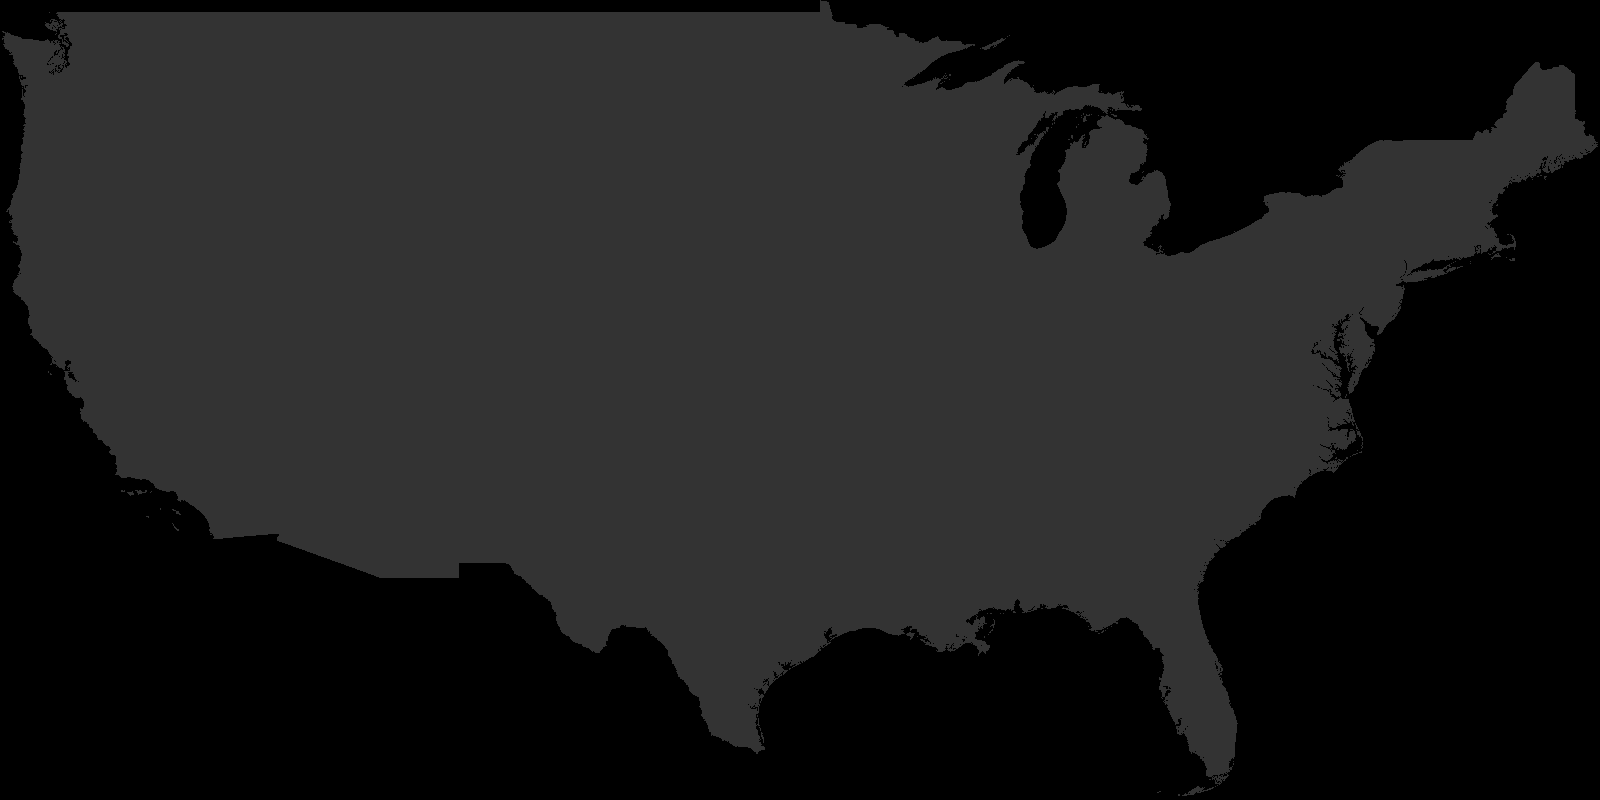

In [5]:
x_range = (-124.848974, -66.885444)
y_range = (24.396308, 49.384358)

W = 1600
H = 800

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=x_range, y_range=y_range)

county_mask = cvs.polygons(county_df, geometry='geometry')
set_background(shade(county_mask, cmap='#333333', alpha=255), 'black')

### Create a "Distance to Nearest Pharmacy" Layer & Classify into 5 Groups

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\xrspatial\classify.py:304: Warning: natural_breaks Warning: Natural break classification (Jenks) has a complexity of O(n^2), your classification with 1280000 data points may take a long time.
  warnings.warn('natural_breaks Warning: Natural break classification '


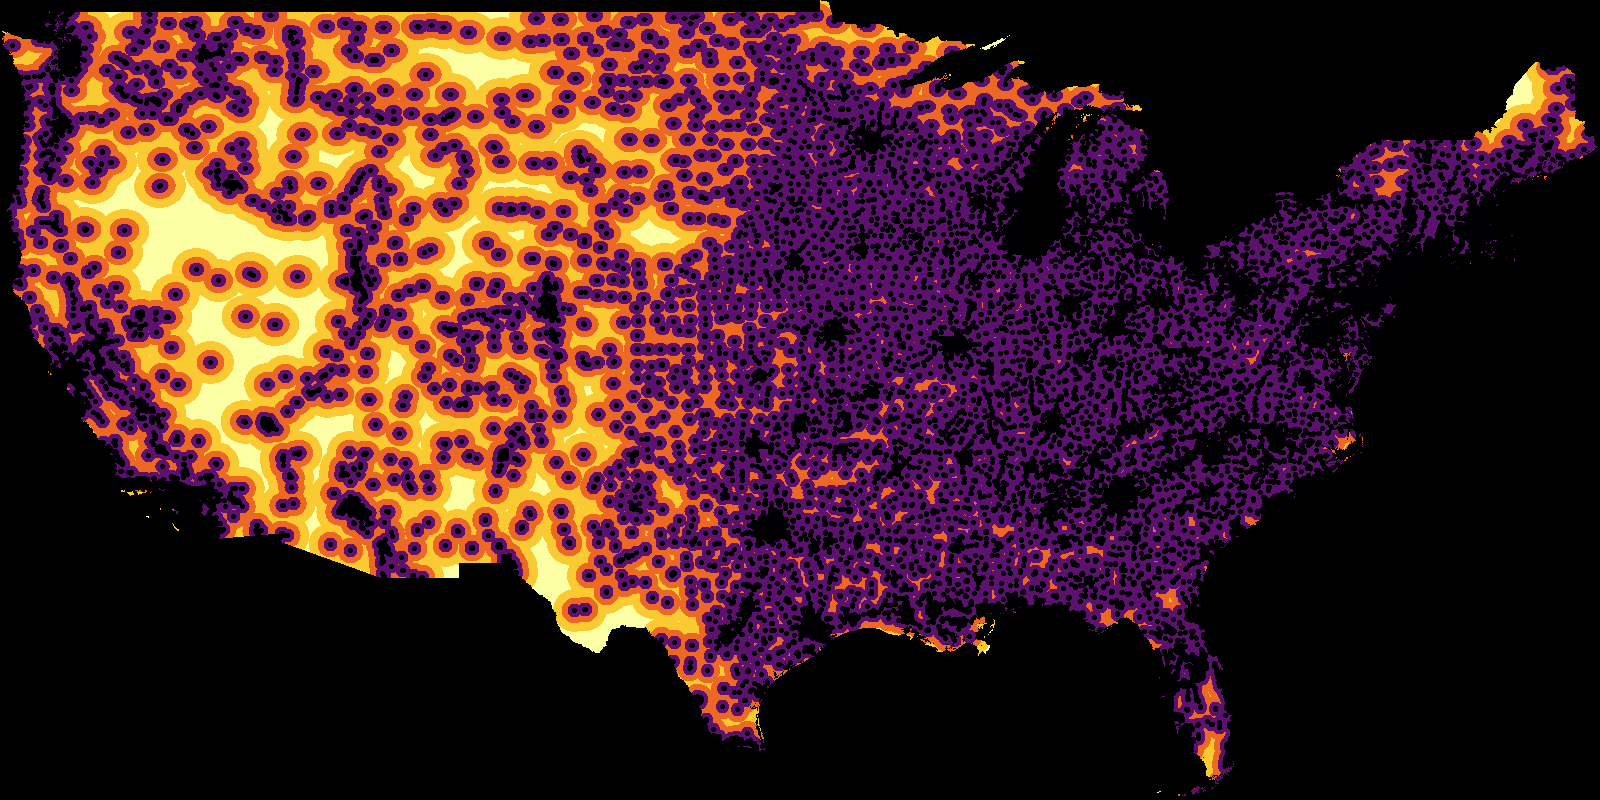

In [6]:
pharmacy_raster = cvs.points(pharmacy_df, 'x', 'y')
proximity_raster = proximity(pharmacy_raster, distance_metric='GREAT_CIRCLE').where(county_mask)
proximity_raster.data[~np.isfinite(proximity_raster.data)] = 0.0

proximity_classifed = natural_breaks(proximity_raster, k=5).where(county_mask)

image_pharmacy = shade(proximity_classifed, cmap=inferno, alpha=255)
image_pharmacy = set_background(image_pharmacy, 'black')
image_pharmacy

### Create an Age Layer  & Classify into 5 Groups

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\xrspatial\classify.py:304: Warning: natural_breaks Warning: Natural break classification (Jenks) has a complexity of O(n^2), your classification with 1280000 data points may take a long time.
  warnings.warn('natural_breaks Warning: Natural break classification '


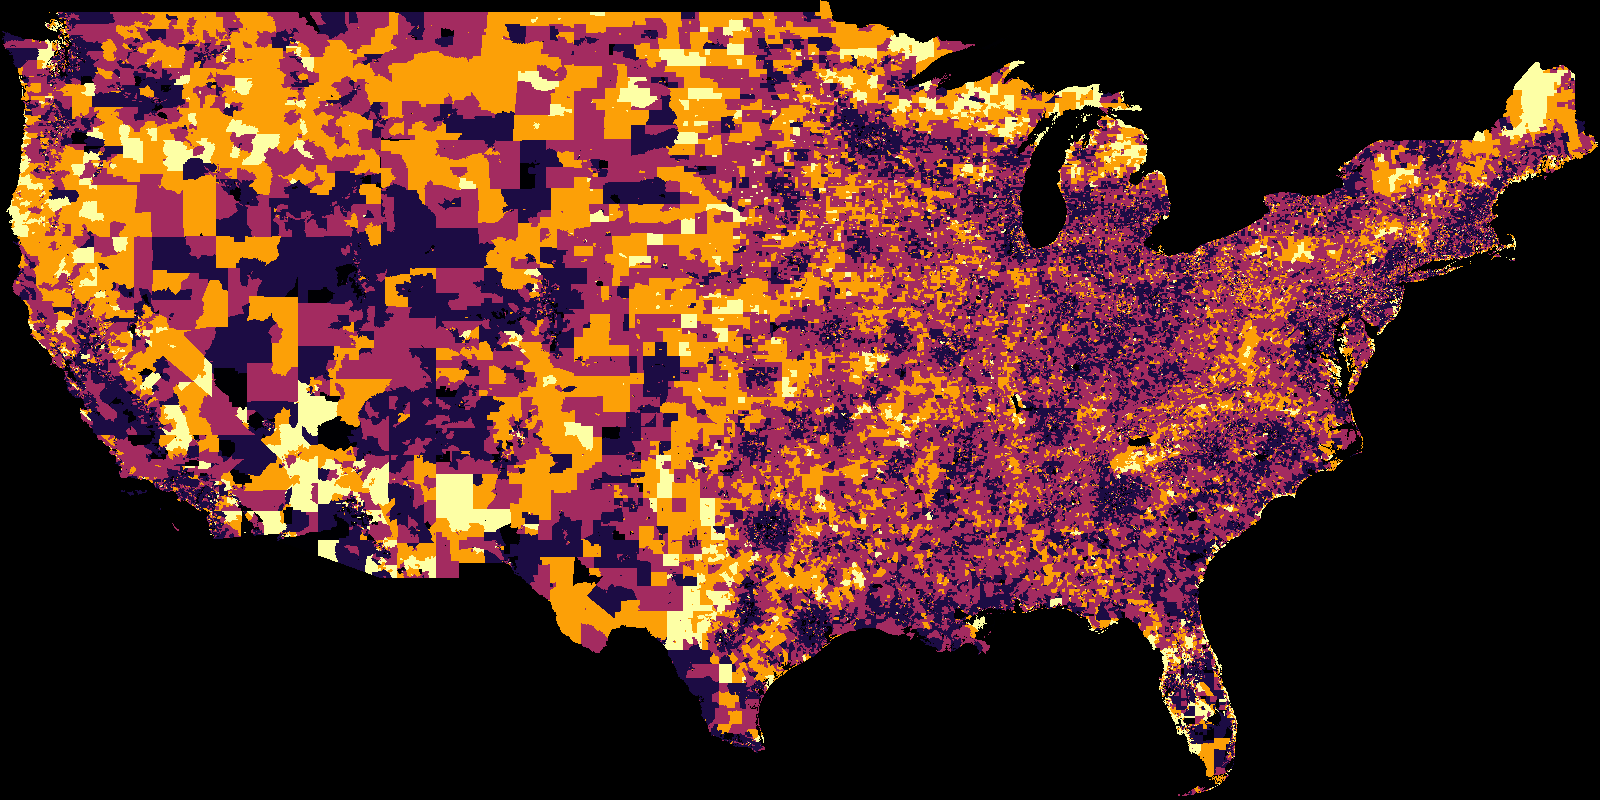

In [7]:
age_raster = cvs.polygons(blockgroup_df, geometry='geometry', agg=ds.mean('PCT_ABOVE_65'))
age_raster.data[~np.isfinite(age_raster.data)] = 0.0
age_classifed = natural_breaks(age_raster, k=5).where(county_mask)

age_image = shade(age_classifed, cmap=inferno, alpha=255)
age_image = set_background(age_image, 'black')
age_image

### Combine layers to highlight seniors at risk from pharmacy deserts

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


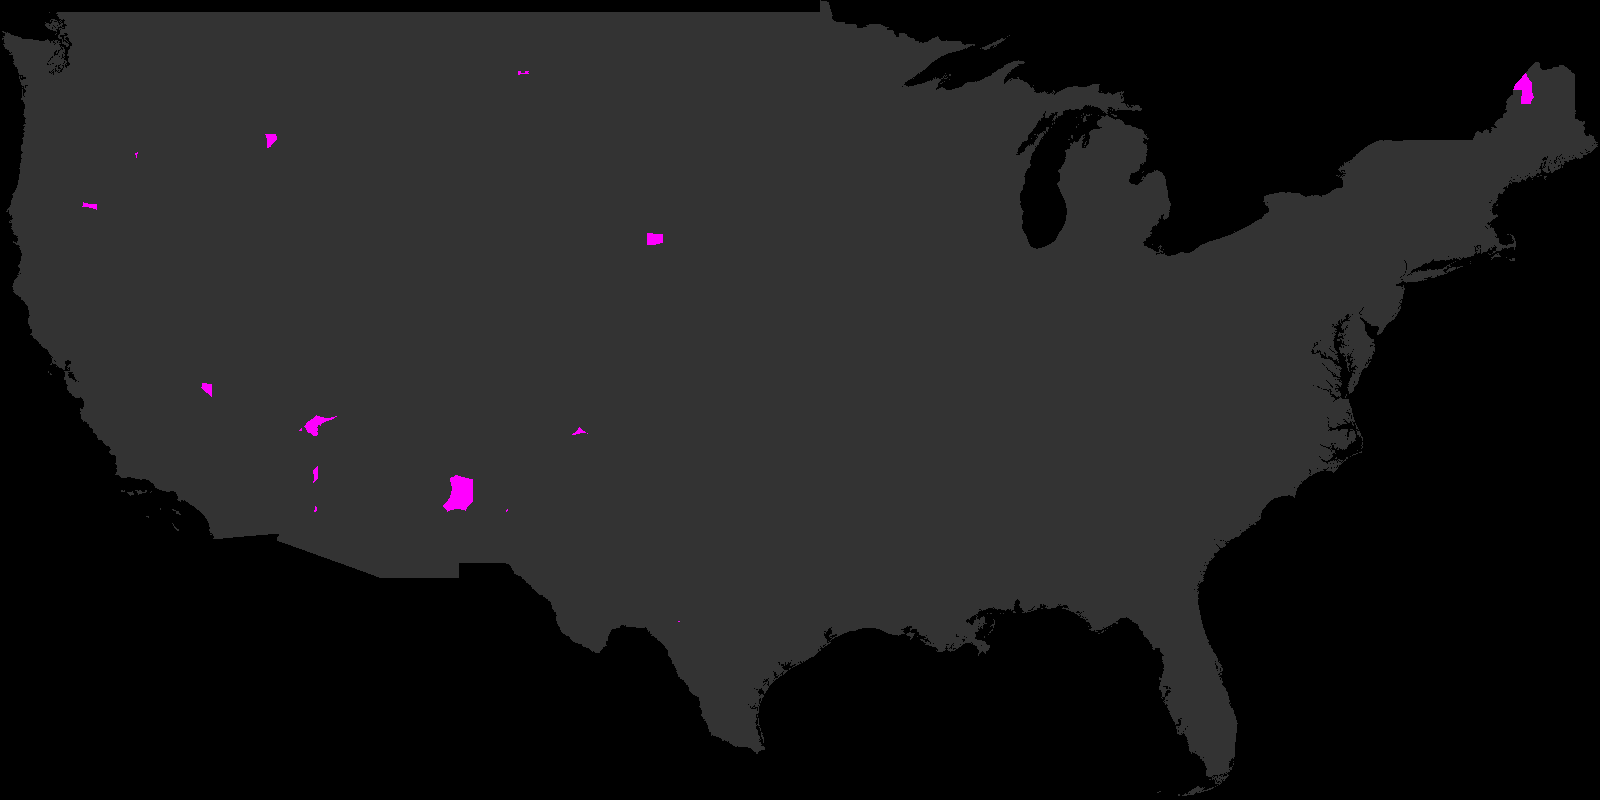

In [8]:
pharmacy_deserts = binary(proximity_classifed, [4.0])
older_regions = binary(age_classifed, [4.0])
target_deserts = (pharmacy_deserts * older_regions).where(county_mask)
target_deserts_img = shade(target_deserts, cmap=['#333333', 'fuchsia'], alpha=255, how='linear')
set_background(target_deserts_img, 'black')

###  Summarize seniors at risk by county

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


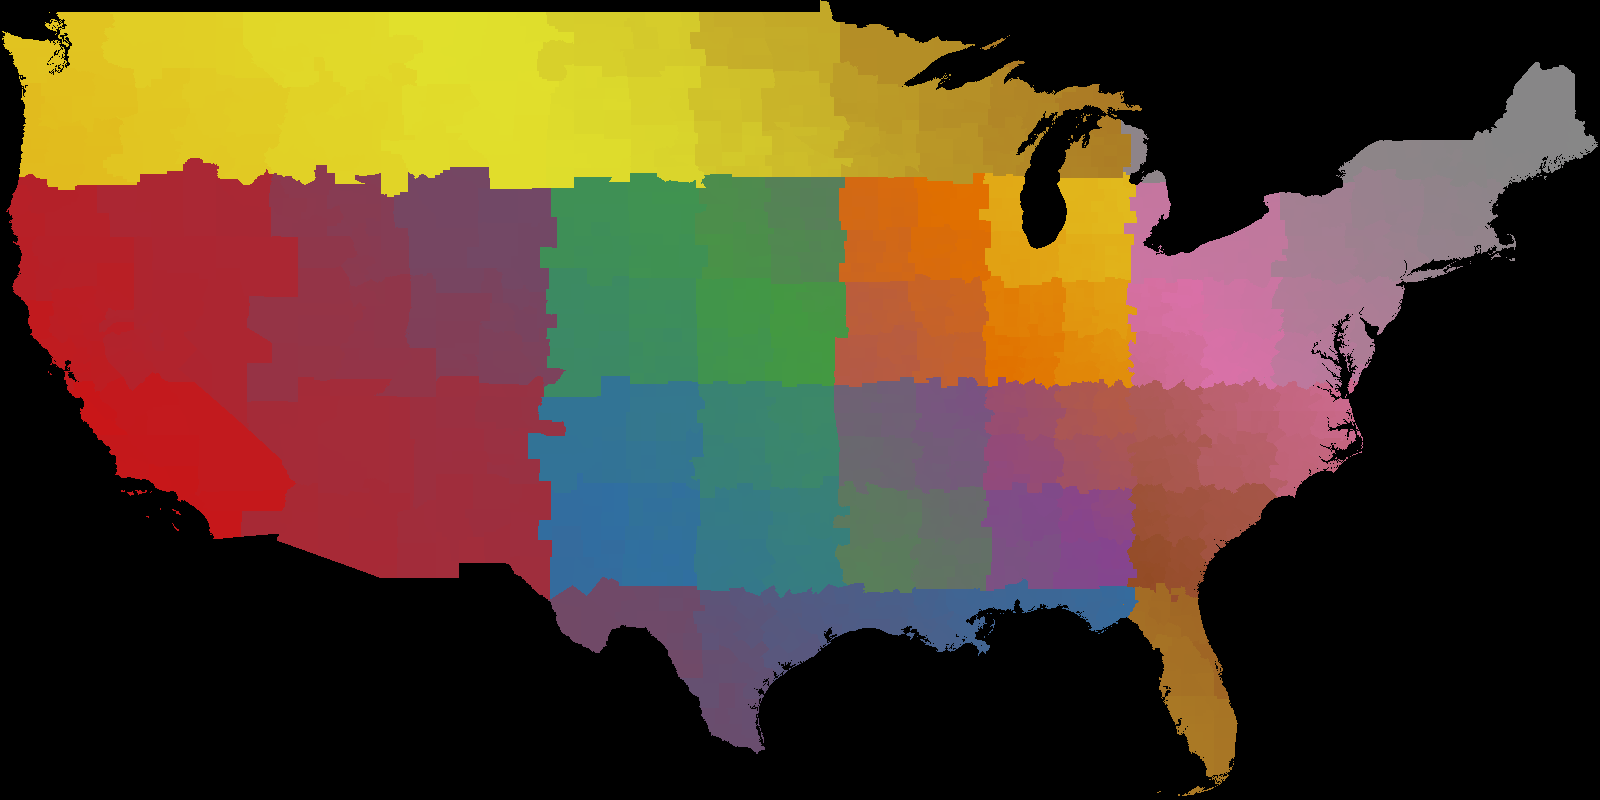

In [9]:
from datashader.colors import Set1

counties_raster = cvs.polygons(county_df, geometry='geometry', agg=ds.max('OBJECTID'))
counties_image = shade(counties_raster, cmap=Set1, alpha=225, how='linear')
set_background(counties_image, 'black')

## Zonal Statistics

Zonal statistics allows for calculating summary statistics for specific areas or zones within a datashader aggregate. Zones are defined by creating an integer aggregate where the cell values are zone_ids. The output of zonal statistics is a Pandas dataframe containing summary statistics for each zone based on a value raster.


In [10]:
from xrspatial import zonal_stats

# summary functions
zonal_funcs = dict(pharmacy_desert_mean=lambda z: z.mean())

# zones
counties_raster.data = counties_raster.data.astype(np.int64)

# values to summarize
target_deserts.data = target_deserts.data.astype(np.int8)

# execute summary functions on each zone and take top 10
results = zonal_stats(counties_raster, target_deserts, zonal_funcs)

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Join result back to counties layer

In [11]:

cols = ['pharmacy_desert_mean', 'NAME', 'STATE_FIPS', 'geometry']
final_df = pd.merge(county_df, results, left_on='ZONE_ID', right_index=True)[cols]
final_df.nlargest(10, 'pharmacy_desert_mean')

,pharmacy_desert_mean,NAME,STATE_FIPS,geometry
752,0.945055,Hooker,31,"MultiPolygon([[[-100.84613006899997, 42.088166..."
137,0.483290,Catron,35,"MultiPolygon([[[-109.04615698099997, 34.579291..."
3217,0.130435,Piscataquis,23,"MultiPolygon([[[-69.72105006899994, 46.5738570..."
104,0.114558,Esmeralda,32,"MultiPolygon([[[-117.16578005599996, 37.535149..."
1945,0.110542,Valley,16,"MultiPolygon([[[-114.72390137499997, 45.089614..."
3215,0.107726,Aroostook,23,"MultiPolygon([[[-69.20438401099995, 47.4523890..."
125,0.104873,Mohave,04,"MultiPolygon([[[-113.67851417899999, 34.209832..."
482,0.096033,Harding,35,"MultiPolygon([[[-104.00894199999999, 36.217891..."
2018,0.056522,Prairie,30,"MultiPolygon([[[-105.40623701299995, 47.181564..."
86,0.040496,Klamath,41,"MultiPolygon([[[-122.00267497299996, 43.615228..."


In [12]:
from xrspatial import hillshade

counties_raster = cvs.polygons(county_df, geometry='geometry', agg=ds.max('OBJECTID'))

desert_raster = cvs.polygons(final_df.nlargest(10, 'pharmacy_desert_mean'),
                             geometry='geometry',
                             agg=ds.mean('pharmacy_desert_mean'))

county_mask = cvs.polygons(county_df, geometry='geometry')

C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\programs\Anaconda3\envs\pharmacy-deserts\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


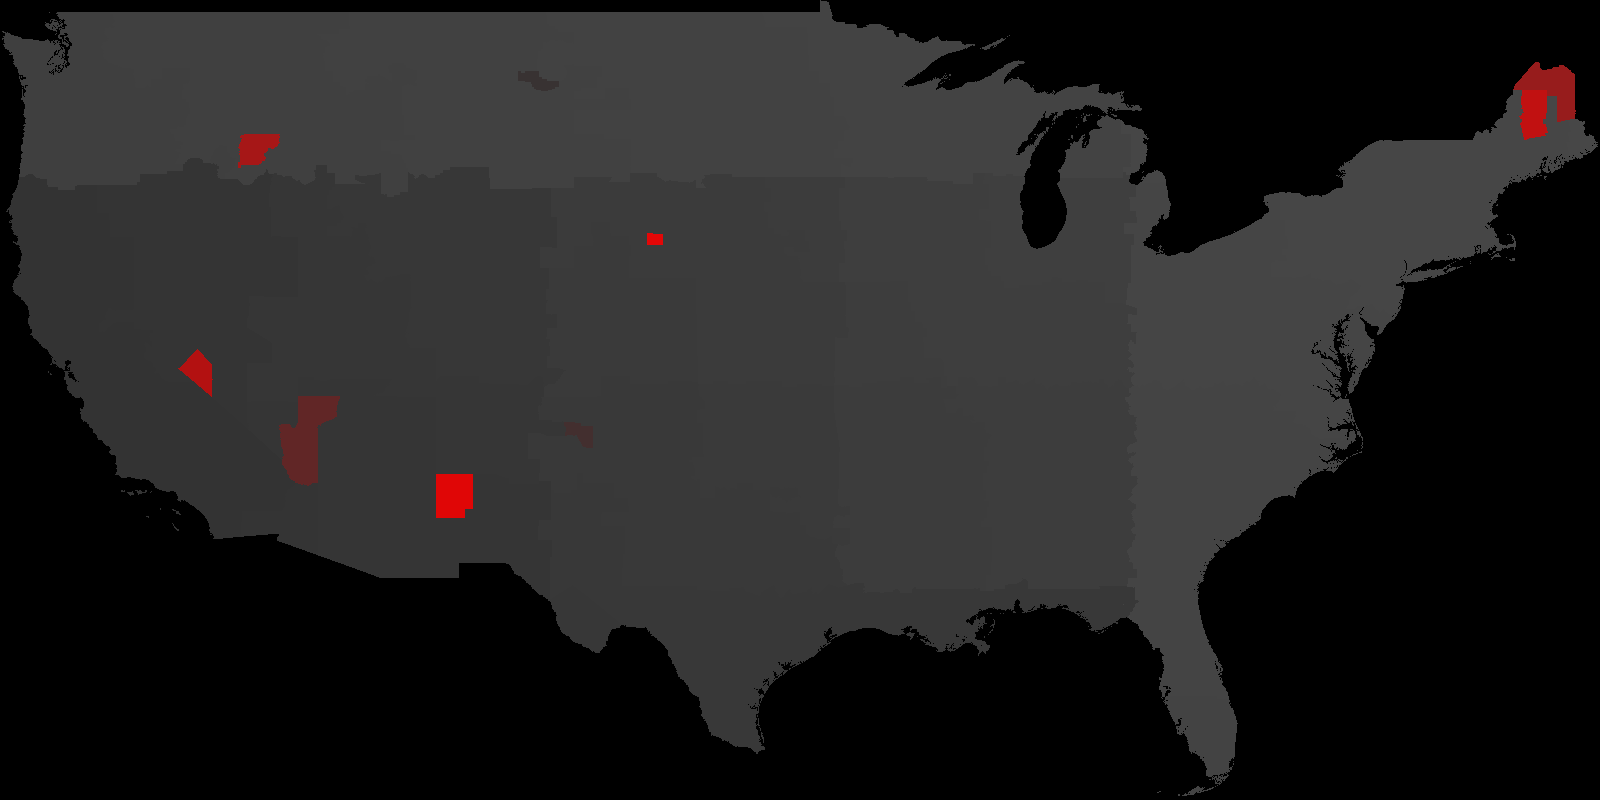

In [13]:
img = stack(
    shade(county_mask, cmap=['#333333'], alpha=255),
    shade(counties_raster, cmap=['#333333', '#ffffff'], alpha=25),
    shade(desert_raster, cmap=['#333333','#ff0000'], alpha=200),
    shade(hillshade(desert_raster), cmap=['#333333', '#ff0000'], alpha=100),
)
set_background(img, 'black')